# <center>Collectors Activities History Analysis</center>
#### <center>Author: Pedro Correia de Siracusa</center>
#### <center>Date: Sep 03, 2017</center>

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import mpld3

import matplotlib.pyplot as plt
from mpld3 import plugins

sns.set_style('darkgrid')

%matplotlib inline

In [2]:
colsList = ['scientificName', 'taxonRank', 'family', 
            'stateProvince', 'locality', 'municipality', 
            'recordedBy', 'identifiedBy',
            'eventDate']

occs = pd.read_table('./0077202-160910150852091/occurrence.txt', usecols=colsList, 
                    parse_dates=['eventDate'], dtype={'recordedBy':np.str})

occs = occs[occs['eventDate'].notnull()]

---

## Time Series Analysis

##### Goals
* Discover patterns in collectors' recording behavior;
* Find temporal anomalies in the dataset.

### Temporal anomalies

My goal is this notebook is to find out how to look for both **contextual** and **collective** temporal anomalies in the occurrences dataset. A thorough discussion about some of the most popular techniques for dealing with different classes of complex anomalies is available at this survey paper:

> Kandhari, R., Chandola, V., Banerjee, A., Kumar, V., & Kandhari, R. (2009). Anomaly detection. ACM Computing Surveys, 41(3), 1–6. https://doi.org/10.1145/1541880.1541882

To start off I'll create my names normalized names index, so I can refer to the normalized names of each collector. I'll just call it `d`. Notice that I'm also importing some functions I've built in previous notebooks.

In [3]:
from mymodules.functions import namesFromString, normalize, getNamesIndices

collectorsNames = set( n for names in occs['recordedBy'].apply( lambda x:namesFromString(str(x)) ) for n in names )
namesMap = dict( (n, normalize(n)) for n in collectorsNames )
d = getNamesIndices(occs, 'recordedBy', namesMap)

Let's start with the example of *Kuhlmann, M*'s recording history. As Figure 1 shows there is a considerably long period of inactivity ranging between 1963 and 2008 (45 years). In addition, if we considered his entire recording history, this person would have a 87 years-long career as a field recordist. A little bit of intuition tells us that there's probably no collector with such recording pattern. This is a typical case where we would detect a **collective anomaly**, as an overall anomalous pattern emerges from the entire set of data despite each data instance being apparently normal in ther particular contexts.

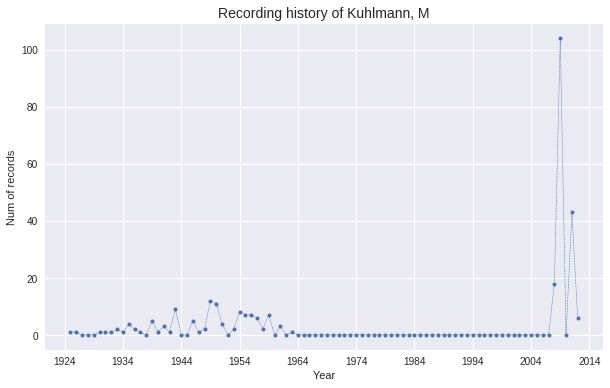

In [4]:
kuhlmann_ts = occs.loc[d['kuhlmann,m']].set_index('eventDate',drop=True)

plt.figure(figsize=(10,6))
plt.plot(kuhlmann_ts['scientificName'].resample(rule='AS').count(), ls='--', marker='.', lw=0.5, ms=8)
plt.title("Recording history of Kuhlmann, M", fontsize=14)
plt.ylabel("Num of records")
plt.xlabel("Year")

**Figure 1. Specimens occurrence recording history of *Kuhlmann, M*. Records numbers were aggregated by year.** 

Two possible explanations for this anomaly are:
1. There are two distinct entities in this dataset that were mapped to the same normalized name `'kuhlmann,m'`. In other words, this kind of analysis could potentially help to distinguish between homonymous entities;
2. Many records were misdated. 

We could further look for patterns in finer scales for each of these two "chunks" of activity and then judge which of the cases above would be more likely.

Now let's check the recording history of *Munhoz,CBR* in Figure 2. In contrast to *Kuhlman*'s, there are no apparent anomalies in *Munhoz*'s recording history. A 26 years-long career is fair enough for a botanic expert. 

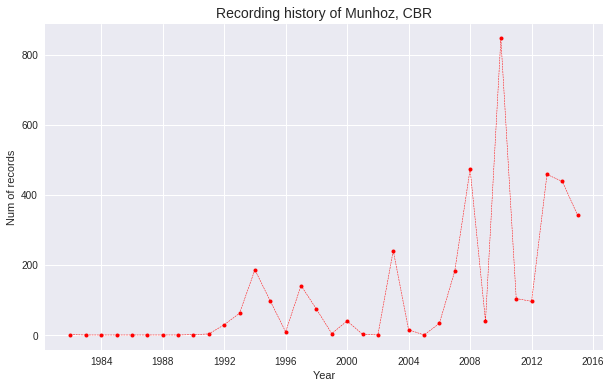

In [5]:
munhoz_ts = occs.loc[d['munhoz,cbr']].set_index('eventDate',drop=True)

plt.figure(figsize=(10,6))
plt.plot(munhoz_ts['scientificName'].resample(rule='AS').count(), ls='--', marker='.', lw=0.5, ms=8, c='r')

plt.title("Recording history of Munhoz, CBR", fontsize=14)
plt.ylabel("Num of records")
plt.xlabel("Year")

**Figure 2. Specimens occurrence recording history of *Munhoz, CBR*. Records numbers were aggregated by year.** 

However, note that *Munhoz*'s time series actually ranges from 1982 to 2015, although there was virually no activity from 1982 to 1990. It is probably the case that there is a single misdated record at 1982 starting her time series earlier. Let's check it.

In [6]:
munhoz_ts.sort_index().head()

,recordedBy,stateProvince,municipality,locality,identifiedBy,scientificName,family,taxonRank
eventDate,,,,,,,,
1982-07-03 02:00:00,"Barros, MAG; Filgueiras, TS; Silva, PEN; Munho...",Distrito Federal,Brasília,"Parque Nacional de Brasília, próximo ao portão...",NaN,Cestrum strigillatum Ruiz & Pav.,Solanaceae,SPECIES
1990-08-04 02:00:00,"Sakuragui, CM; Munhoz, CBR; Souza, VC",Minas Gerais,Diamantina,Lado esquerdo da Rodovia Diamantina-Curvelo ca...,"Arbo, MM",Turnera dichotoma Gardner,Turneraceae,SPECIES
1991-04-24 02:00:00,"Nascimento, AE; Barros, M; Munhoz, CBR; et al.",Distrito Federal,Brasília,"Acampamento da Telebrasília, lago Paranoá",NaN,Bidens L.,Asteraceae,GENUS
1991-04-24 02:00:00,"Nascimento, AE; Barros, M; Munhoz, CBR",Distrito Federal,Brasília,"Acampamento da Telebrasília, lago Paranoá",NaN,Asteraceae,Asteraceae,FAMILY
1991-05-27 02:00:00,"Munhoz, CBR",Goiás,NaN,NaN,Incógnito,Epiphyllum phyllanthus (L.) Haw.,Cactaceae,SPECIES


How can we "trim" a collector's time series to obtain a more accurate range of activities? In other words I want to discriminate individual records that are significantly distant in time to clusters of activity. I propose a solution that gets the timestamp difference (delta time) between a record and its nearest neighbors. Actually there are three distinct rules for this algorithm. The first I called the **lowest time delta**, which computes the distances between a record and its neighbors in the timeline and returns the lowest one. The **highest time delta** rule is similar to the first one, except that it returns the highest distance. The third rule, called the **neighbors time delta** is the distance between the two neighbors of a given record, which can also be computed as the sum of the lowest and highest time deltas for a given record except for the first and last records in the time series. In all cases if the record is the first or the last one in the time series then the distance to its only neighbor is calculated. Below is the implemented algorithm.

In [7]:
def getTimeDelta( timeseries, rule='lowest' ):
    """ 
        Computes time deltas.
        Rules: 
          'lowest': Gets the lowest time delta between an element and its neighbors
          'highest': Gets the highest time delta between an element and its neighbors
          'neighbors': Gets the time delta between the two neighbors of an element
        
        Returns:
            A time delta index.
    """
    timeseries = timeseries[timeseries.notnull()].sort_values()
    timeseries = pd.DatetimeIndex(timeseries)
    
    delta_firsttwo = timeseries[1] - timeseries[0] 
    delta_lasttwo = timeseries[-1] - timeseries[-2]    
        
    prev_neighbrs = timeseries[:-2]
    next_neighbrs = timeseries[2:]
    
    
    if rule =='lowest' or rule=='highest':
        current_ts = timeseries[1:-1] 
        delta_with_prev = pd.Series(current_ts - prev_neighbrs)
        delta_with_next = pd.Series(next_neighbrs - current_ts)
        d1,d2 = delta_with_prev.align(delta_with_next)
        if rule=='lowest':
            res = pd.TimedeltaIndex(pd.np.fmin(d1,d2))
        else:
            res = pd.TimedeltaIndex(pd.np.fmax(d1,d2))

    elif rule=='neighbors':
        res = next_neighbrs-prev_neighbrs
        
    
    res = res.insert(  0, delta_firsttwo ) 
    res = res.insert( -1, delta_lasttwo ) 
    
    return res

The *interactive* Figure 3 below shows the temporal distributions of time deltas for both collectors *Munhoz* and *Kuhlmann*. The *highest delta time* metric allows us to detect records that are in the edges of clusters of activity. In the case of *Kuhlmann*, for example, there are two points that are extremely distant to each other, indicating an anomaly. Also, a high mean value for the highest deltas from 1925 to 1965 might be an indicative that records were mostly obtained sparsely in time, which could be itself an important anomaly for collectors behavior. This is something to verify. For the *lowest delta time* metric, high values characterize records that are isolated in time from others and are possibly outliers. However if two records that are distant to others occur close in time the latter metric fails to indicate them as outliers. We could try to perform **anomaly detection** by using some clustering algorithm starting from records with sufficiently high *highest delta times*. We would therefore start by the "edges" of distant clusters of activities and select all the records which are part of those groups.

In [8]:
munhoz_ts = munhoz_ts[munhoz_ts.index.notnull()].sort_index()
munhoz_ts['lowestTimeDelta'] = getTimeDelta( munhoz_ts.index, 'lowest' )
munhoz_ts['highestTimeDelta'] = getTimeDelta( munhoz_ts.index, 'highest' )

kuhlmann_ts = kuhlmann_ts[kuhlmann_ts.index.notnull()].sort_index()
kuhlmann_ts['lowestTimeDelta'] = getTimeDelta( kuhlmann_ts.index, 'lowest' )
kuhlmann_ts['highestTimeDelta'] = getTimeDelta( kuhlmann_ts.index, 'highest' )

In [9]:
f, (ax1, ax2) = plt.subplots(figsize=(12,12), nrows=2, ncols=1, sharex=True, sharey=True)

ax1.plot(munhoz_ts['highestTimeDelta'].apply(lambda t: t.days), ls='', marker='.', c='g', zorder=1)
ax1.plot(munhoz_ts['lowestTimeDelta'].apply(lambda t: t.days), ls='', marker='.', c='r', zorder=2 )
ax1.legend(['highest time delta', 'lowest time delta'])
ax1.set_title("Time deltas of records by Munhoz, CBR", fontsize=14)

ax2.plot(kuhlmann_ts['highestTimeDelta'].apply(lambda t: t.days), ls='', marker='.', c='g', zorder=1)
ax2.plot(kuhlmann_ts['lowestTimeDelta'].apply(lambda t: t.days), ls='', marker='.', c='r', zorder=2 )
ax2.set_title("Time deltas of records by Kuhlmann, M", fontsize=14)

plt.xlabel("Year")
plt.ylabel("Time delta")
mpld3.display()

**Figure 3.**

To exemplify I will now use the *lowest time delta* metric to identify distant outliers and trim *Munhoz*'s time series. I'll use a somewhat arbitrary value of 1000 days as the threshold for detecting the outlier. More realistic values to be used as thresholds could be learned from the data if we trained a classifier with "normal" time series data from other collectors.

In [10]:
munhoz_ts[munhoz_ts['lowestTimeDelta'].apply(lambda x: x.days) > 1000]

,recordedBy,stateProvince,municipality,locality,identifiedBy,scientificName,family,taxonRank,lowestTimeDelta,highestTimeDelta
eventDate,,,,,,,,,,
1982-07-03 02:00:00,"Barros, MAG; Filgueiras, TS; Silva, PEN; Munho...",Distrito Federal,Brasília,"Parque Nacional de Brasília, próximo ao portão...",NaN,Cestrum strigillatum Ruiz & Pav.,Solanaceae,SPECIES,2954 days,2954 days


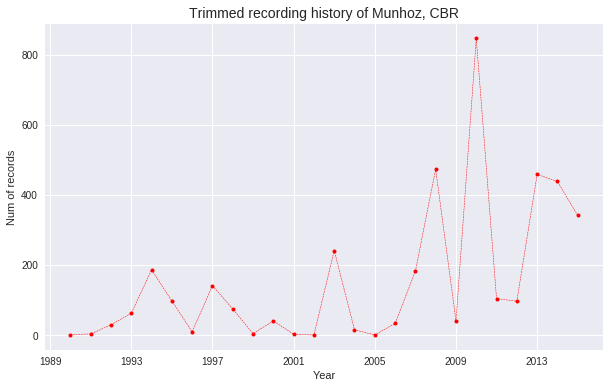

In [11]:
munhoz_trimmed = munhoz_ts[munhoz_ts['lowestTimeDelta'].apply(lambda x: x.days) < 1000]

plt.figure(figsize=(10,6))
plt.plot(munhoz_trimmed['scientificName'].resample(rule='AS').count(), ls='--', marker='.', lw=0.5, ms=8, c='r')

plt.title("Trimmed recording history of Munhoz, CBR", fontsize=14)
plt.ylabel("Num of records")
plt.xlabel("Year")

## Applying the metrics to the entire dataset

Now how can the time delta metric be calculated to the entire dataset? 
* Time deltas must be calculated for each collector and stored in a separate dataframe. This is because records may be associated to different time deltas depending on the collector we're considering.

In [12]:
collectorsNames = set( n for names in occs['recordedBy'].apply( lambda x:namesFromString(str(x)) ) for n in names )
namesMap = dict( (n, normalize(n)) for n in collectorsNames )

d = getNamesIndices(occs, 'recordedBy', namesMap)

Here I'm rewriting my `getTimeDelta` function to be executed more optimally.

In [13]:
def getTimeDelta( df, timecol='eventDate', rule='lowest' ):
    # there must be no null elements in timecol
    # this function must be run for each individual entity (supports parallelization)
    
    timeseries = df[timecol].sort_values()
    
    prev_neighbrs = timeseries.shift(1)
    next_neighbrs = timeseries.shift(-1)
    
    delta_with_prev = timeseries.subtract( prev_neighbrs )
    delta_with_next = delta_with_prev.shift(-1)
    
    d1,d2 = delta_with_prev.align(delta_with_next)
    
    if rule=='lowest':
        return pd.np.fmin(d1,d2)
    
    elif rule=='highest':
        return pd.np.fmax(d1,d2)
    
    elif rule=='both':
        res = pd.concat( [pd.np.fmin(d1,d2), pd.np.fmax(d1,d2)], axis=1 )
        res.columns=['lowest_timedelta','highest_timedelta']
        return res

Now I build the `collectors_timedeltas` dataframe. This takes a while, as we're processing all records from each collector sequentially. As there are no data dependencies for computing timedeltas for collectors individually, this function could be parallelized to run faster.

In [14]:
collectors = d.keys()

collectors_timedeltas = pd.DataFrame.from_items( 
    ( (i, (c,l,h)) for c in collectors for (i,(l,h)) in getTimeDelta(occs.loc[d[c]], rule='both').iterrows() ), 
    orient='index', columns=['collector','lowest_timedelta','highest_timedelta'] )

In [15]:
collectors_timedeltas_days = collectors_timedeltas.copy()
collectors_timedeltas_days['lowest_timedelta'] = collectors_timedeltas['lowest_timedelta'].apply(lambda td:td.days)
collectors_timedeltas_days['highest_timedelta'] = collectors_timedeltas['highest_timedelta'].apply(lambda td:td.days)

In [16]:
collectors_timedeltas_days.head(15)

,collector,lowest_timedelta,highest_timedelta
58334,"ferreira,rc",28.0,28.0
43544,"ferreira,rc",28.0,28.0
85391,"mello,ar",0.0,0.0
99907,"mello,ar",0.0,1.0
85360,"mello,ar",0.0,1.0
99895,"mello,ar",0.0,0.0
99902,"mello,ar",0.0,213.0
107410,"mello,ar",213.0,213.0
28733,"figueiredo,m",0.0,0.0
28752,"figueiredo,m",0.0,0.0


Now let's quickly try to detect some outliers by checking the `lowest_timedelta` metric. Here I'll use 10000 days as the limit above which records will be considered outliers (*i.e.*, they're more than 10000 days distant to their nearest neighbors in time).

In [17]:
outliers = collectors_timedeltas_days[collectors_timedeltas_days['lowest_timedelta']>10000]

Here are some records classified as outliers, sorted by the "importance" of the collector (total number of records by him/her).

In [18]:
occs_outliers = outliers.join(occs)
occs_outliers['total_records'] = occs_outliers['collector'].apply(lambda x: len(d[x]))
occs_outliers.sort_values('total_records', ascending=False).head()

,collector,lowest_timedelta,highest_timedelta,recordedBy,eventDate,stateProvince,municipality,locality,identifiedBy,scientificName,family,taxonRank,total_records
67219,"ratter,ja",16079.0,16079.0,"Ratter, JA",1922-10-24 01:00:00,Minas Gerais,NaN,Aproximadamente 10km W of Januária.,NaN,Pseudobombax Dugand,Malvaceae,GENUS,5121
35968,"carvalho,am",11719.0,11719.0,"Carvalho, AM",1936-01-21 01:00:00,São Paulo,Campinas,Avenida Brasil,"Sebastiani, R",Janusia guaranitica (A. St.-Hil.) A. Juss.,Malpighiaceae,SPECIES,1430
168887,"philcox,d",10577.0,10577.0,"Philcox, D",1938-01-16 01:00:00,Mato Grosso,NaN,80 Km N de Xavantina para Cachimbo,"Delprete, PG",Spermacoce vulpina (Standl.) Govaerts,Rubiaceae,SPECIES,1318
13631,"gomesjunior,jc",12068.0,12068.0,"Gomes Júnior, JC",1998-04-16 02:00:00,NaN,NaN,NaN,NaN,Vernonanthura phosphorica (Vell.) H.Rob.,Asteraceae,SPECIES,1112
39434,"lima,as",10284.0,12107.0,"Lima, AS",1978-09-05 01:00:00,São Paulo,Moji Mirim,"Estrada rodagem, Km 153.","Aranha, C",Annona dioica A. St.-Hil.,Annonaceae,SPECIES,380


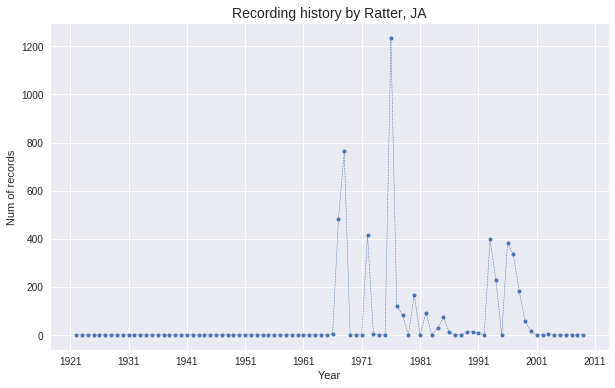

In [19]:
col_ts = occs.loc[d['ratter,ja']].set_index('eventDate',drop=True)

plt.figure(figsize=(10,6))
plt.plot(col_ts['scientificName'].resample(rule='AS').count(), ls='--', marker='.', lw=0.5, ms=8)
plt.title("Recording history by Ratter, JA", fontsize=14)
plt.ylabel("Num of records")
plt.xlabel("Year")

We can also use the `collectors_timedeltas` dataframe to create a map with collectors recording histories. The collectors history, which is indexed by both the collectors normalized name and the record id, can be used to directly access his records and timedeltas. 

In [20]:
collectors_history = collectors_timedeltas.copy()
collectors_history['recordId'] = collectors_history.index
collectors_history.set_index(keys=['collector', 'recordId'], inplace=True)

For example let's get the records by *Ratter, JA* and trim his timeseries by removing extreme outliers:

In [21]:
ratter_ts = collectors_history.loc['ratter,ja'].join(occs).set_index('eventDate').sort_index()
ratter_ts_trimmed = ratter_ts[ratter_ts['lowest_timedelta'].apply(lambda x: x.days)<10000]

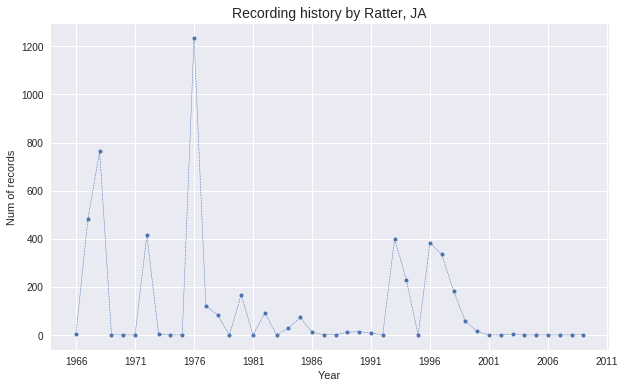

In [22]:
plt.figure(figsize=(10,6))
plt.plot(ratter_ts_trimmed['scientificName'].resample(rule='AS').count(), ls='--', marker='.', lw=0.5, ms=8)
plt.title("Recording history by Ratter, JA", fontsize=14)
plt.ylabel("Num of records")
plt.xlabel("Year")